In [1]:
from ConvNeXtUNet.convnextv2_unet import convnextv2unet_atto
from ConvNeXtUNet.losses.MultiScaleLoss import MultiScaleLoss

import mlflow

mlflow.autolog()
mlflow.set_experiment("ConvNeXtV2-UNet")


/Users/joe/Development/ryan/ConvNeXt-V2-UNet/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025/06/16 12:50:15 INFO mlflow.tracking.fluent: Experiment with name 'ConvNeXtV2-UNet' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///Users/joe/Development/ryan/ConvNeXt-V2-UNet/examples/mlruns/187479759740700411', creation_time=1750103415105, experiment_id='187479759740700411', last_update_time=1750103415105, lifecycle_stage='active', name='ConvNeXtV2-UNet', tags={}>

In [2]:
# Three models with predefined sizes are provided
model = convnextv2unet_atto(ms_output=True)

Now, lets do a simple image denoising task as a demonstration of the U-Net

In [3]:
import torch
import matplotlib.pyplot as plt

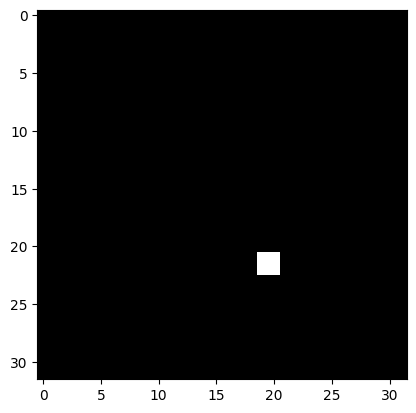

In [4]:
# This function creates a synthetic image
# We can add noise to this to simulate a noisy image

import random


def create_random_pixel_image(channels, height, width):
    """
    Generates a 2D tensor (image) of zeros with a single '1' at the center pixel.

    Args:
    channels: The channels of the image (number of channels).
    height: The height of the image (number of rows).
    width: The width of the image (number of columns).

    Returns:
    A torch.Tensor of shape (height, width) with dtype torch.float32.
    """
    if height <= 0 or width <= 0:
        raise ValueError("Height and width must be positive integers.")

    image = torch.zeros((channels, height, width), dtype=torch.float32)

    pixel_height = random.randint(0, height - 2)
    pixel_width = random.randint(0, width - 2)

    for channel in range(channels):
        image[channel, pixel_height, pixel_width] = 1.0
        image[channel, pixel_height + 1, pixel_width + 1] = 1.0
        image[channel, pixel_height, pixel_width + 1] = 1.0
        image[channel, pixel_height + 1, pixel_width] = 1.0

    return image.unsqueeze(0)


sample_image = create_random_pixel_image(3, 32, 32)
plt.imshow(sample_image[0].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00020894408..1.4206698].


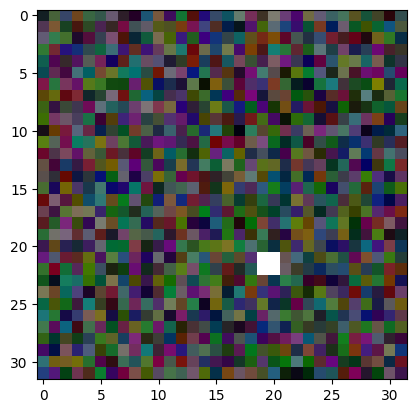

In [5]:
def add_noise(image, scale=0.5):
    B, C, W, H = image.shape
    image += torch.rand(B, C, W, H) * scale
    return image


noisy_sample = add_noise(sample_image)
plt.imshow(noisy_sample[0].permute(1, 2, 0))

Now, let's train our model.

In [6]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("mps")
    if torch.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")


device = get_device()
device

device(type='mps')

In [7]:
# These training parameters are not optimizd and are merely meant to quickly demonstrate training.

num_epochs = 10
num_batches = 10
batch_size = 3

lr = 2e-4
opt = torch.optim.Adam(model.parameters(), lr=lr)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, num_epochs)
loss_func = MultiScaleLoss(loss_criterion=torch.nn.MSELoss())


model = model.to(device)

# model_info = mlflow.pytorch.log_model(model, "model1")

In [8]:
mlflow.start_run()
for epoch in range(num_epochs):
    total_loss_per_batch = 0
    for batch in range(num_batches):
        ground_truth = torch.cat(
            [create_random_pixel_image(3, 32, 32) for _ in range(batch_size)]
        )
        noisy_images = add_noise(ground_truth.clone())

        ground_truth = ground_truth.to(device)
        noisy_images = noisy_images.to(device)

        pred = model(noisy_images)
        loss = loss_func(pred, ground_truth)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss_per_batch += loss
        mlflow.log_metric("loss", loss.item())
    # MSE by default computes the mean, so divide by batches
    print(
        f"Epoch {epoch}: Loss: {total_loss_per_batch / num_batches:.2e} LR: {sched.get_last_lr()[0]:.2e}"
    )
    sched.step()
    mlflow.log_metric("lr", sched.get_last_lr()[0])
mlflow.end_run()

Epoch 0: Loss: 2.48e-01 LR: 2.00e-04
Epoch 1: Loss: 7.12e-02 LR: 1.95e-04
Epoch 2: Loss: 5.27e-02 LR: 1.81e-04
Epoch 3: Loss: 4.20e-02 LR: 1.59e-04
Epoch 4: Loss: 3.43e-02 LR: 1.31e-04
Epoch 5: Loss: 4.54e-02 LR: 1.00e-04
Epoch 6: Loss: 3.56e-02 LR: 6.91e-05
Epoch 7: Loss: 3.85e-02 LR: 4.12e-05
Epoch 8: Loss: 3.42e-02 LR: 1.91e-05
Epoch 9: Loss: 2.99e-02 LR: 4.89e-06


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00017777085..1.441683].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4025962..0.29686502].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.21736035..1.5357946].


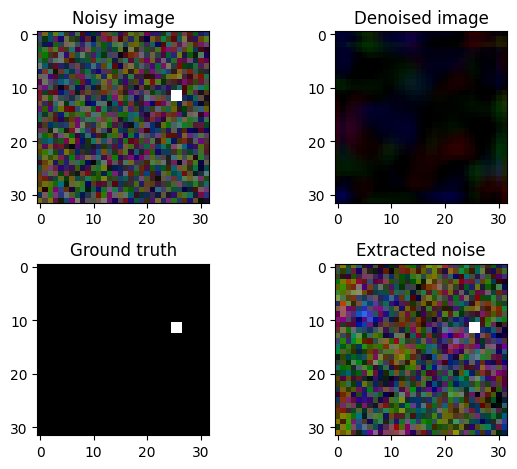

In [9]:
def format_tensor(tensor):
    return tensor.detach().cpu().permute(1, 2, 0)


fig, ax = plt.subplots(nrows=2, ncols=2)

plt.subplot(2, 2, 1)
noisy_img = format_tensor(noisy_images[0])
plt.imshow(noisy_img)
plt.title("Noisy image")

plt.subplot(2, 2, 2)
pred_img = format_tensor(pred[-1][0])
plt.imshow(pred_img)
plt.title("Denoised image")

plt.subplot(2, 2, 3)
gt_image = format_tensor(ground_truth[0])
plt.imshow(gt_image)
plt.title("Ground truth")

plt.subplot(2, 2, 4)
plt.imshow(noisy_img - pred_img)
plt.title("Extracted noise")

plt.tight_layout()
plt.show()